In [1]:
from licheats import Client
from licheats.shared import Game, Player

from typing import List, Dict, Any, Tuple
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
def get_player_games(client: Client, username: str) -> Tuple[Player, List[Game]]:
    """Fetch player and games data from Lichess."""
    player = client.get_player(username)
    games = client.get_games(username)
    return player, games

def analyze_games(player: Player, games: List[Game]) -> Dict[str, Any]:
    """Analyze games and return statistics."""
    stats = {
        'preferred_opening_distribution': defaultdict(int),
        'opening_win_distribution': defaultdict(lambda: {'wins': 0, 'losses': 0, 'total': 0}),
        'win_status_distribution': defaultdict(int),
        'castling_side_distribution': defaultdict(int),
        'castling_win_distribution': defaultdict(int),
        'piece_movement_distribution': defaultdict(int),
        'time_control_distribution': defaultdict(int),
        'win_rate_by_color': {'white': {'wins': 0, 'total': 0}, 'black': {'wins': 0, 'total': 0}},
        'rating_progression': [],
        'game_duration': [],
        'win_reasons': defaultdict(int),
        'loss_reasons': defaultdict(int)
    }

    for game in games:
        player_color = 'white' if game.players_white_id == player.username else 'black'
        player_won = game.winner == player_color
        player_lost = game.winner and game.winner != player_color

        update_stats(game, stats, player_won, player_lost, player_color)

    return stats

def update_stats(game: Game, stats: Dict[str, Any], player_won: bool, player_lost: bool, player_color: str):
    """Update statistics based on a single game."""
    # Opening analysis
    if game.opening_eco:
        stats['preferred_opening_distribution'][game.opening_eco] += 1
        stats['opening_win_distribution'][game.opening_eco]['total'] += 1
        if player_won:
            stats['opening_win_distribution'][game.opening_eco]['wins'] += 1
        elif player_lost:
            stats['opening_win_distribution'][game.opening_eco]['losses'] += 1

    # Game outcome
    stats['win_status_distribution'][game.status] += 1

    # Castling analysis
    moves = game.moves.split()
    for move in moves:
        if 'O-O-O' in move:
            stats['castling_side_distribution']['queen'] += 1
            stats['castling_win_distribution']['queen_win' if player_won else 'queen_loss'] += 1
        elif 'O-O' in move:
            stats['castling_side_distribution']['king'] += 1
            stats['castling_win_distribution']['king_win' if player_won else 'king_loss'] += 1
        
        if move[0].isupper() and move[0] in 'PNBRQK':
            stats['piece_movement_distribution'][move[0]] += 1

    # Time control
    stats['time_control_distribution'][game.speed] += 1

    # Win rate by color
    stats['win_rate_by_color'][player_color]['total'] += 1
    if player_won:
        stats['win_rate_by_color'][player_color]['wins'] += 1

    # Rating progression
    player_rating = game.players_white_rating if player_color == 'white' else game.players_black_rating
    stats['rating_progression'].append((game.created_at, player_rating))

    # Game duration
    if game.last_move_at and game.created_at:
        duration = (game.last_move_at - game.created_at).total_seconds()
        stats['game_duration'].append(duration)

    # Win/Loss reasons
    if player_won:
        stats['win_reasons'][game.status] += 1
    elif player_lost:
        stats['loss_reasons'][game.status] += 1

def plot_opening_wins_losses(stats: Dict[str, Any]):
    """Plot wins and losses by opening."""
    data = pd.DataFrame([
        {
            'Opening': opening,
            'Wins': outcomes['wins'],
            'Losses': outcomes['losses'],
            'Total': outcomes['total']
        }
        for opening, outcomes in stats['opening_win_distribution'].items()
    ])

    data = data.sort_values('Total', ascending=False).head(10)  # Top 10 most played openings
    data.set_index('Opening')[['Wins', 'Losses']].plot(kind='bar', stacked=True, color=['green', 'red'])
    plt.ylabel('Number of Games')
    plt.title('Wins and Losses by Opening (Top 10)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_game_outcomes(stats: Dict[str, Any]):
    """Plot game outcome distribution."""
    data = pd.DataFrame(list(stats['win_status_distribution'].items()), columns=['Outcome', 'Count'])
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Outcome', y='Count', data=data, palette='pastel')
    plt.title('Game Outcomes')
    plt.xlabel('Outcome')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_piece_movements(stats: Dict[str, Any]):
    """Plot piece movement distribution."""
    data = pd.DataFrame(list(stats['piece_movement_distribution'].items()), columns=['Piece', 'Movements'])
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Piece', y='Movements', data=data, palette='deep')
    plt.title('Piece Movement Distribution')
    plt.xlabel('Chess Pieces')
    plt.ylabel('Number of Movements')
    plt.tight_layout()
    plt.show()

def plot_castling_results(stats: Dict[str, Any]):
    """Plot castling results."""
    data = pd.DataFrame([
        {'Category': 'King', 'Result': 'Wins', 'Count': stats['castling_win_distribution']['king_win']},
        {'Category': 'King', 'Result': 'Losses', 'Count': stats['castling_win_distribution']['king_loss']},
        {'Category': 'Queen', 'Result': 'Wins', 'Count': stats['castling_win_distribution']['queen_win']},
        {'Category': 'Queen', 'Result': 'Losses', 'Count': stats['castling_win_distribution']['queen_loss']}
    ])
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Category', y='Count', hue='Result', data=data, palette={'Wins': 'green', 'Losses': 'red'})
    plt.title('Castling Results')
    plt.xlabel('Castling Type')
    plt.ylabel('Count')
    plt.legend(title='Result')
    plt.tight_layout()
    plt.show()

def plot_rating_progression(stats: Dict[str, Any]):
    """Plot rating progression over time."""
    data = pd.DataFrame(stats['rating_progression'], columns=['Date', 'Rating'])
    data.set_index('Date', inplace=True)
    
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Rating'])
    plt.title('Rating Progression Over Time')
    plt.xlabel('Date')
    plt.ylabel('Rating')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_time_control_distribution(stats: Dict[str, Any]):
    """Plot time control distribution."""
    data = pd.DataFrame(list(stats['time_control_distribution'].items()), columns=['Time Control', 'Count'])
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Time Control', y='Count', data=data, palette='Set3')
    plt.title('Time Control Distribution')
    plt.xlabel('Time Control')
    plt.ylabel('Number of Games')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_win_rate_by_color(stats: Dict[str, Any]):
    """Plot win rate by color."""
    data = pd.DataFrame([
        {'Color': color, 'Win Rate': data['wins'] / data['total'] * 100 if data['total'] > 0 else 0}
        for color, data in stats['win_rate_by_color'].items()
    ])
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Color', y='Win Rate', data=data, palette={'white': 'lightgray', 'black': 'darkgray'})
    plt.title('Win Rate by Color')
    plt.xlabel('Color')
    plt.ylabel('Win Rate (%)')
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

In [3]:
PLAYER_USERNAME = 'Fieber69'
client = Client()
player, games = get_player_games(client, PLAYER_USERNAME)
# client.save_player(player)
# client.save_games(games)

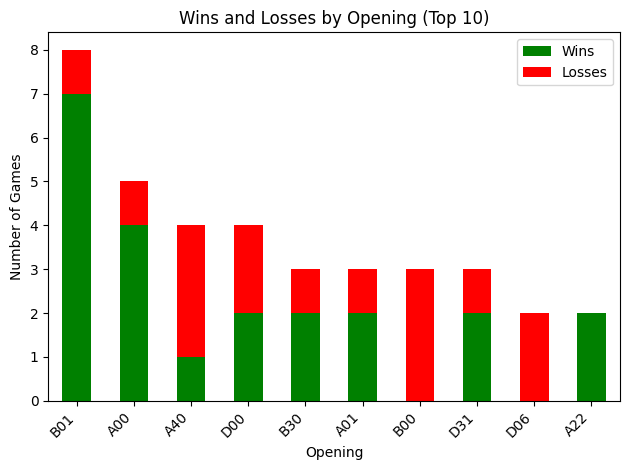

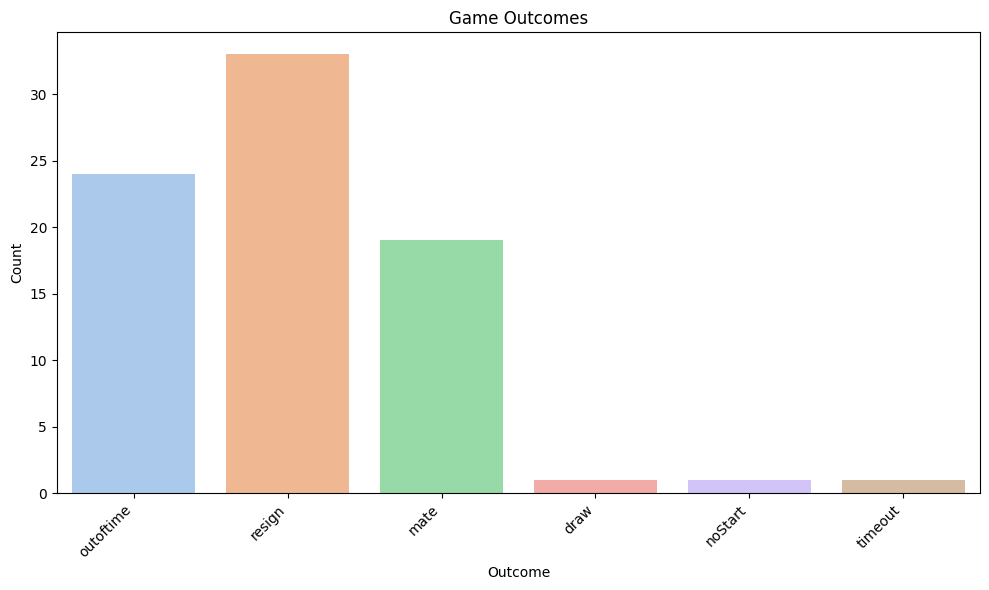

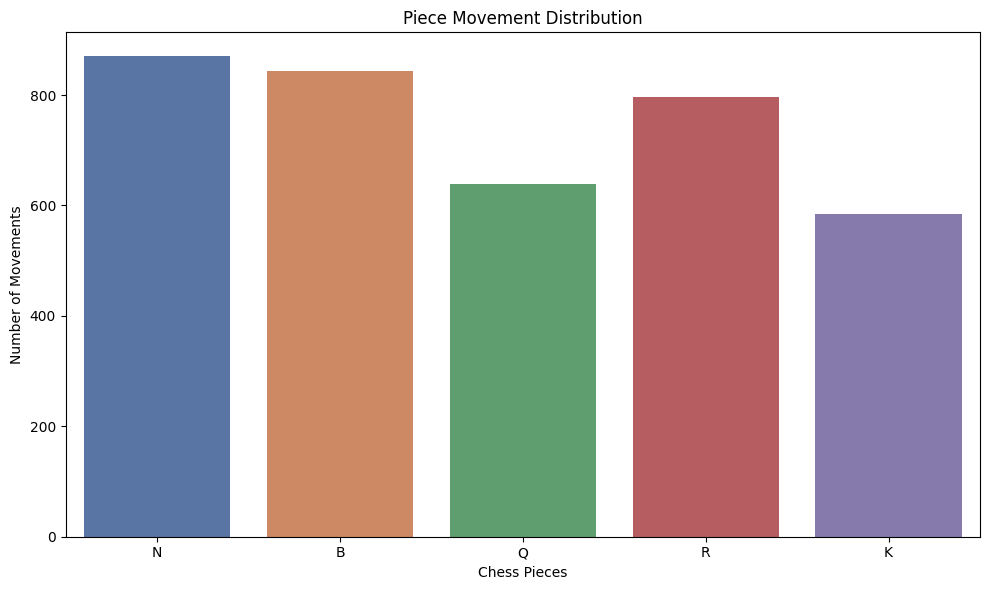

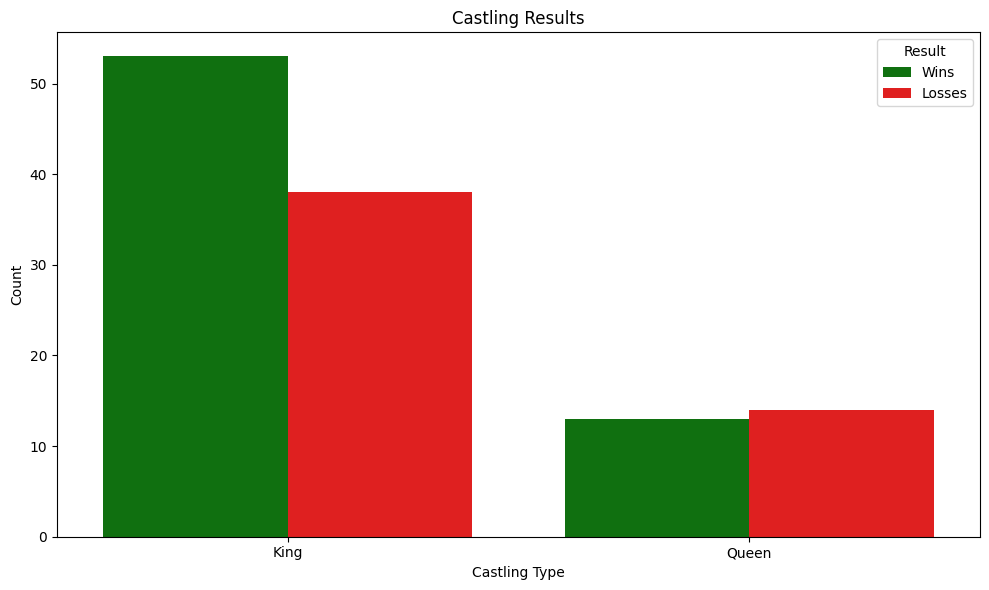

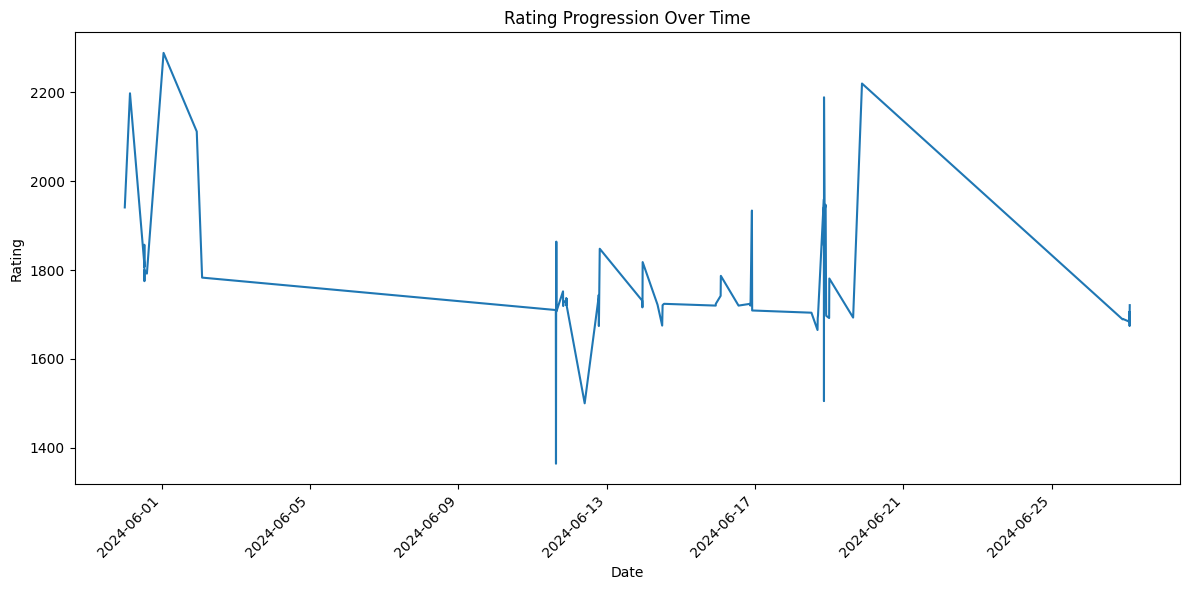

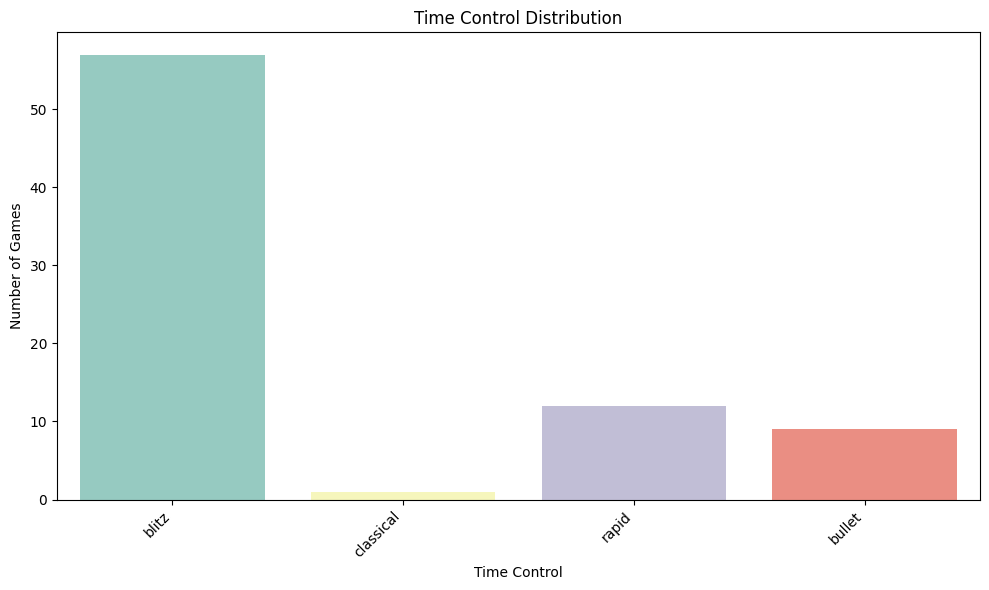

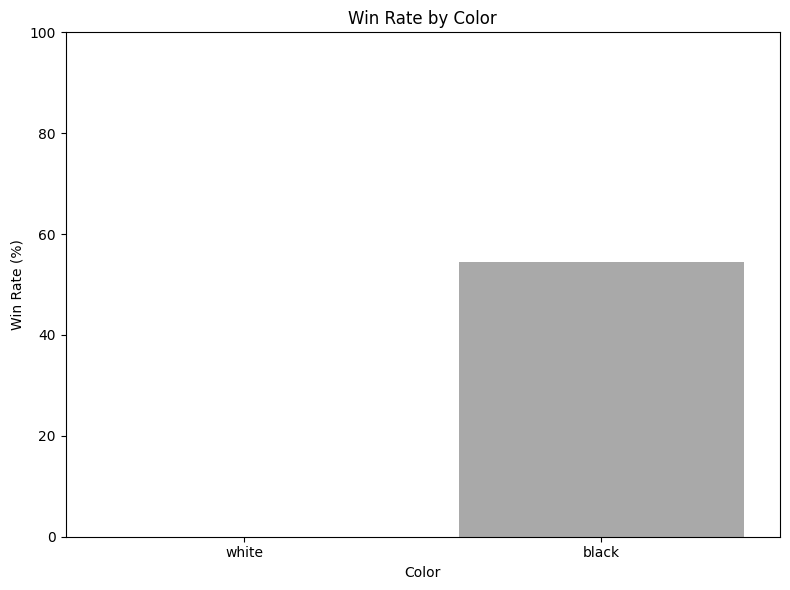

In [4]:
stats = analyze_games(player, games)
plot_opening_wins_losses(stats)
plot_game_outcomes(stats)
plot_piece_movements(stats)
plot_castling_results(stats)
plot_rating_progression(stats)
plot_time_control_distribution(stats)
plot_win_rate_by_color(stats)